In [1]:
# imPORT LIBRARIES 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from math import pi, sqrt
import handcalcs.render
import pandas as pd
import json 
# !pip install handcalcs

In [45]:
# CONFIGURATIONS
#help(handcalcs.set_option)
handcalcs.set_option("latex_block_start", "$")
handcalcs.set_option("latex_block_end", "$")
handcalcs.set_option("math_environment_end", "aligned")
handcalcs.set_option("use_scientific_notation",True)
#handcalcs.set_option("line_break", "\\\\[20pt]")
#handcalcs.set_option("param_columns", 1)

#handcalcs.set_option("math_environment_start", "aligned")
#handcalcs.set_option("math_environment_end", "aligned")
#handcalcs.set_option("line_break", r"<br>")
#handcalcs.set_option("line_break", r"\\")
from handcalcs.decorator import handcalc

In [46]:
from localcode import *
fig_counter=1

ModuleNotFoundError: No module named 'localcode'

# EMI Filter <a class="title_class" id="title_1"></a>

## Inputs and claculated parameters <a class="title_class" id="title_2"></a>

In [47]:
with open("../01_llc_tank/04_outputs/inp_datas.json", "r", encoding="utf-8") as f:
    inp_datas = json.load(f)
#print("Input datas:")
#print("="*20)
#display(inp_datas)
S= pd.Series(inp_datas, name = "Input datas").to_frame()
display(S)

with open("../01_llc_tank/04_outputs/out_results.json", "r", encoding="utf-8") as f:
    out_datas = json.load(f)
#print("Output datas:")
#print("="*20)
#display(out_datas)

S= pd.Series(out_datas, name = "Output datas").to_frame()
display(S)


# Load variables 
for key, value in inp_datas.items():
    globals()[key] = value
for key, value in out_datas.items():
    globals()[key] = value

,Input datas
V_In_min,360.0
V_In_nom,380.0
V_In_max,400.0
Vo_min,42.0
Vo_nom,48.0
Vo_max,54.0
Power,1200.0
f_nom,100000.0


,Output datas
Lnc,3.000000e+00
Qec,5.500000e-01
Cr_nF,1.162090e+02
n,4.000000e+00
Lr_uH,2.179700e+01
Lm_uH,6.539200e+01
fsw_min,6.017000e+04
fsw_max,1.562200e+05
Im_rms,6.992000e+00
Io,2.500000e+01


## DRAFT

PA2756NLT

https://www.mouser.fr/datasheet/2/447/P688-2903753.pdf

In [48]:
df=pd.read_csv(r'../../03_components/06_EMI_Filter/PA2756NL.csv')
df = df[['Freq_Mhz', 'Z_ohm']]
df.head(5)

,Freq_Mhz,Z_ohm
0,0.202750,533.421982
1,0.407478,766.235644
2,0.606492,838.488159
3,0.812311,902.712618
4,1.011335,995.035276


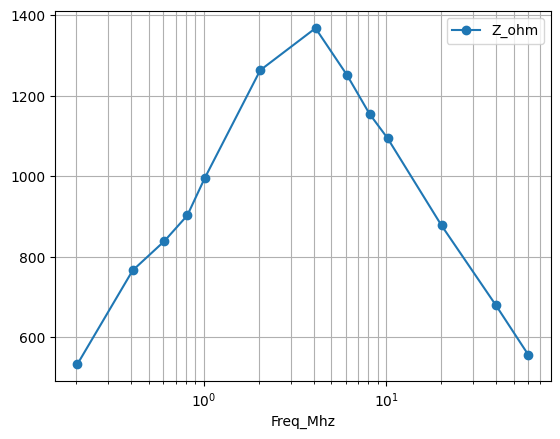

In [69]:
df.plot(x= "Freq_Mhz", y= "Z_ohm",marker="o")
plt.xscale("log")
plt.grid(which="both")

$$ F_{res} = \frac{ 1 }{ 2 \cdot \pi \cdot \sqrt { \mathrm{Lcm} \cdot \mathrm{Cp} } } $$

In [189]:
%%render 
Fres_Mhz=4 # Mhz
Lcm_uH= 484 # µH

<IPython.core.display.Latex object>

In [190]:
%%render
Cp_pF=1e12 / ((2*pi)**2*(Fres_Mhz*1e6)**2*Lcm_uH*1e-6) # pF

<IPython.core.display.Latex object>

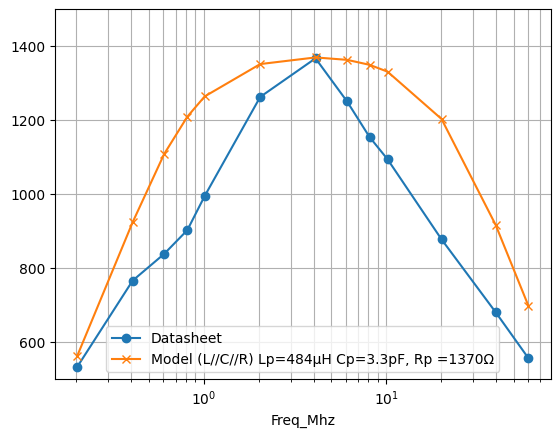

In [199]:
def Z_parallel_RLC_mag(R, L, C, f):
    w = 2 * np.pi * f
    Y = (1/R) + (1/(1j * w * L)) + (1j * w * C)  # Admittance
    Z = 1 / Y
    return np.abs(Z)  # magnitude only
#Z_parallel_RLC_mag(R, L, C, f)

f= df.Freq_Mhz*1e6
L= Lcm_uH*1e-6
C= Cp_pF*1e-12
R=1370

df.plot(x= "Freq_Mhz", y= "Z_ohm",marker="o",label ="Datasheet")
Z= Z_parallel_RLC_mag(R, L, C, f)
plt.plot(f/1e6,Z, 
         label = f"Model (L//C//R) Lp={Lcm_uH}µH Cp={Cp_pF:.1f}pF, Rp ={R}Ω",
        marker="x")

w = 2 * np.pi * f
L=L/100
ZL= w * L
#plt.plot(f/1e6,ZL)
plt.xscale("log")
#plt.yscale("log")
plt.ylim([500, 1500])
plt.grid(which="both")
plt.legend()

NCU15XH103J6SRC

https://www.mouser.fr/datasheet/2/281/NCU15XH103J6SRC-1519743.pdf

## Output capacitor Co <a class="title_class" id="title_3"></a>

### Formulas <a class="title_class" id="title_4"></a>

For a resistive load, the output capacitor is determined by

$$
C_o \geq C_{o_{min}}
$$

$$
C_{o_{min}} = \frac{I_o}{8 \cdot f_{sw} \cdot \Delta V_{outC}}
$$

Where:

- $C_o$ : Output capacitance (Farads, F)  
- $I_o$ : Output load current (Amperes, A)  
- $f_{sw}$ : Switching frequency of the converter (Hertz, Hz)  
- $\Delta V_{out}$ : Maximum allowed output voltage ripple (Volts, V)  

$$
ESR_{max} = \frac{\Delta V_{outR}}{I_{rect\_peak}}
$$

$$
I_{rect\_peak} = \frac{\pi}{4} \cdot I_o \cdot 2
$$

$$
I_{C_o} = I_o \sqrt{\frac{\pi^2}{8} - 1}
$$

Where:

- $I_{C_o}$ : RMS current of the capacitor @ $f_{sw} = f_{nom}$

And the total ripple voltage can be: 
- $V_{out} ≈ V_{outR}+ V_{outC}$
  
In this design we will verify:
- $ V_{outR} < \frac{V_{outMax}}{2}$
- $ V_{outC} < \frac{V_{outMax}}{2}$


See page 26, 27 [\[1\]](#referencesID_03_1).  
By default, you can find all formulas of this chapter in the same reference.


### Numerical Implementation of the Formulas <a class="title_class" id="title_5"></a>

**We must use fsw_min to the worst case**

In [47]:
%%render long
Io # A
fsw_min # Hz
DV = 0.25 # vpp
Co_min_uF = 1e6*Io/(8*fsw_min*DV ) # uF
ESR_max_m = 1e3*DV /(Io*pi/2) # mΩ 
I_Co= Io*sqrt(pi**2/8-1) # Arms

<IPython.core.display.Latex object>

In [48]:
%%render long
Io # A
fsw_min # Hz
DV = 0.25 # vpp
Co_min_uF = 1e6*Io/(8*fsw_min*DV ) # uF
ESR_max_m = 1e3*DV /(Io*pi/2) # mΩ 
I_Co= Io*sqrt(pi**2/8-1) # Arms

<IPython.core.display.Latex object>

### First proposition <a class="title_class" id="title_6"></a>

B40910A8127M000 aluminum electrolytic capacitors with Temp_max = 150°C, Below a screenshoot of the datasheet [\[2\]](#referencesID_03_2).

In [49]:
first_part_path = "./03_figures/"

fig_counter = One_figure_with_captions(
    fig_counter, 
    "B40910.png",
    "B40910A8127M000 aluminum electrolytic capacitors with Temp_max = 150°C",
    first_part_path= first_part_path, 
)

Let's start with a configuration of 5 capacitors in parallel

In [50]:
%%render long
#4 parallels capascitor
Nb_capa= 6
C_capa_nom = 120 # uF
Margin = 20 #\%
C_capa = C_capa_nom*(1-Margin/100)# uF, Worst case 
C_eq = C_capa*Nb_capa # uF > 208uF ok
ESR_capa= 17 # Ω @ 100kHz

ESR_eq = ESR_capa/Nb_capa # Ω < 6.36m OK
Icapa_max = 4.6
Ieq_max = Icapa_max *Nb_capa  #  @ Arms @ 125°C 100kHz > 12.08Arms ok

<IPython.core.display.Latex object>

**Voltage ripples**

In [51]:
%%render long
Delta_V_outC = Io/(8*fsw_min*C_eq*1e-6 )

I_rect_peak= Io*pi/2

Delta_V_outR = I_rect_peak*ESR_eq*1e-3

Delta_V_out = Delta_V_outR+ Delta_V_outC # < 0.25mV

<IPython.core.display.Latex object>

#### Self heating

**Power Dissipation of Each Capacitor**

In [52]:
%%render long
I_each_capa= I_Co/Nb_capa
P_selfHeating = ESR_capa*1e-3*I_each_capa**2 # W

<IPython.core.display.Latex object>

**Estimation of Thermal Resistance Rth**

In [53]:
%%render long
# Estimation or Rth 

# @100Khz and 125°C Iac,R I=4.6A
# 100KHZ 20°C ESR = 0.017 Ohm 
# Max T = 150°C 
Delta_T= 150-125 # °C
ESR = 17e-3
I = 4.6 # Arms
P_dissip= ESR*I**2 # W
R_th = Delta_T/P_dissip # °C/W

<IPython.core.display.Latex object>

**The self heating estimation and the max ambiant temp**

In [54]:
%%render long
# self heating 
Delta_T= P_selfHeating*R_th # °C => low delta temp
Margin = 30 # °C 
T_max = 150
T_amb_max = T_max -Delta_T-Margin  # °C 

<IPython.core.display.Latex object>

**Voltage margin**

In [55]:
%%render long 
Vo_max # VDC
V_max_datasheet = 63 # VDC
Voltage_Margin =  100*(V_max_datasheet-Vo_max) /V_max_datasheet # \%

<IPython.core.display.Latex object>

This solution is acceptable, but the voltage margin is limited.

In [56]:
dic_capa1= {}
for x in "C_capa,ESR_eq,C_eq,Ieq_max,Nb_capa,P_selfHeating,T_amb_max,Voltage_Margin,Delta_V_out".split(","):
    dic_capa1[x]= eval(x)

### Second proposition <a class="title_class" id="title_7"></a>

EMHS101ARA331MMN0S aluminum electrolytic capacitors with Temp_max = 150°C, Below a screenshoot of the datasheet [\[4\]](#referencesID_03_4).

In [57]:
first_part_path = "./03_figures/"

fig_counter = One_figure_with_captions(
    fig_counter, 
    "EMHS.png",
    "EMHS101ARA331MMN0S aluminum electrolytic capacitors with Temp_max = 150°C",
    first_part_path= first_part_path, 
)

Let's start with a configuration of 5 capacitors in parallel

In [58]:
%%render long
#4 parallels capascitor
Nb_capa= 10
C_capa_nom = 330 # uF
Margin = 20 #\%
C_capa = C_capa_nom*(1-Margin/100)# uF, Worst case 
C_eq = C_capa*Nb_capa # uF > 208uF ok
ESR_capa= 59 # Ω @ 100kHz

ESR_eq = ESR_capa/Nb_capa # Ω < 6.36m OK
Icapa_max = 2.3

Ieq_max = Icapa_max *Nb_capa  #  @ Arms 
#@ 125°C 100kHz > 12.08Arms ok

<IPython.core.display.Latex object>

**Voltage ripples**

In [59]:
%%render long
Delta_V_outC = Io/(8*fsw_min*C_eq*1e-6 )

I_rect_peak= Io*pi/2

Delta_V_outR = I_rect_peak*ESR_eq*1e-3

Delta_V_out = Delta_V_outR+ Delta_V_outC # clause to 0.25mV

<IPython.core.display.Latex object>

#### Self heating

**Power Dissipation of Each Capacitor**

In [60]:
%%render long
I_each_capa= I_Co/Nb_capa
P_selfHeating = ESR_capa*1e-3*I_each_capa**2 # W

<IPython.core.display.Latex object>

**Estimation of Thermal Resistance Rth**

In [61]:
%%render long
# Estimation or Rth 

# @100Khz and 125°C Iac,R I=4.6A
# 100KHZ 20°C ESR = 0.017 Ohm 
# Max T = 150°C 
Delta_T= 150-125 # °C
P_dissip= ESR_capa*1e-3*Icapa_max **2 # W
R_th = Delta_T/P_dissip # °C/W

<IPython.core.display.Latex object>

**The self heating estimation and the max ambiant temp**

In [62]:
%%render long
# self heating 
Delta_T= P_selfHeating*R_th # °C => low delta temp
Margin = 30 # °C 
T_max = 150
T_amb_max = T_max -Delta_T-Margin  # °C 

<IPython.core.display.Latex object>

In [63]:
%%render long 
Vo_max # VDC
V_max_datasheet = 100 # VDC
Voltage_Margin =  100*(V_max_datasheet-Vo_max) /V_max_datasheet # \%

<IPython.core.display.Latex object>

In [64]:
dic_capa2= {}
for x in "C_capa,ESR_eq,C_eq,Ieq_max,Nb_capa,P_selfHeating,T_amb_max,Voltage_Margin,Delta_V_out".split(","):
    dic_capa2[x]= eval(x)

### Comparaison <a class="title_class" id="title_8"></a>

In [65]:
dic_capa1["VmaxDC"]=63
dic_capa2["VmaxDC"]=100

In [66]:
requirements= {"ESR_eq":ESR_max_m, "C_eq":Co_min_uF, "Ieq_max":I_Co, 
               "VmaxDC":Vo_max, "Delta_V_out":DV}

In [67]:
pd.DataFrame([requirements, dic_capa1, dic_capa2], 
             index= ["requirements","Solutio1", "Solutio2"]).T.round(2)

,requirements,Solutio1,Solutio2
ESR_eq,6.37,2.83,5.90
C_eq,207.74,576.00,2640.00
Ieq_max,12.09,27.60,23.00
VmaxDC,54.00,63.00,100.00
Delta_V_out,0.25,0.20,0.25
C_capa,NaN,96.00,264.00
Nb_capa,NaN,6.00,10.00
P_selfHeating,NaN,0.07,0.09
T_amb_max,NaN,115.21,113.10
Voltage_Margin,NaN,14.29,46.00


The voltage margin in the first solution is limited (16% in the worst case). However, I propose we proceed with this option, given the number of parallel capacitors. Care must be taken in control to prevent any overshoot or transient voltage, especially when Vout is at Vout_max.

## Resonanat capacitor Cr <a class="title_class" id="title_9"></a>

### Chosing a capacitor for Cr <a class="title_class" id="title_10"></a>

**The inputs data**

In [68]:
%%render long
Cr_nF # nF
V_In_max # V
fsw_min # Hz

<IPython.core.display.Latex object>

**The RMS voltage of the resonant capacitor**

In [69]:
%%render long
X_Cr= 1/(2*pi*fsw_min*Cr_nF*1e-9) # Ohm 
V_Cr= Ir_rms*X_Cr # V
V_Cr_rms= sqrt((V_In_max/2)**2+V_Cr**2) # vrms

<IPython.core.display.Latex object>

In [70]:
# https://www.mouser.es/ProductDetail/EPCOS-TDK/B32672L1333J?qs=vht8qxFUkGz11LfwwLq5EA%3D%3D
# https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf

Starting with the **B3267*L** film capacitors, the maximum rated DC voltage is 2000 V. [\[2\]](#referencesID_03_3).

In [71]:
B32672L1333 = [6.2, 6.8, 8.2, 10.0, 12.0, 15.0, 22.0, 33.0, 47.0, 56.0, 68.0]
print(f"The design value of Cr is {Cr_nF:.1f} nF")
print("Below are some possible combinations for constructing this resonant capacitor:")
arr= []
for c in B32672L1333: 
    n= round(Cr_nF/c)
    ct= n*c
    error = 100*(ct-Cr_nF)/Cr_nF
    dic = {"Nominal_capa_nF":c, "Nb capas in parallel": n, 
           "total capa nF" :ct, "error %":round(error, 1)}
    arr.append(dic)
pd.DataFrame(arr)

The design value of Cr is 116.2 nF
Below are some possible combinations for constructing this resonant capacitor:


,Nominal_capa_nF,Nb capas in parallel,total capa nF,error %
0,6.2,19,117.8,1.4
1,6.8,17,115.6,-0.5
2,8.2,14,114.8,-1.2
3,10.0,12,120.0,3.3
4,12.0,10,120.0,3.3
5,15.0,8,120.0,3.3
6,22.0,5,110.0,-5.3
7,33.0,4,132.0,13.6
8,47.0,2,94.0,-19.1
9,56.0,2,112.0,-3.6


**The current of each element capacitor**

In [72]:
%%render 
Ir_rms_1=Ir_rms/8

<IPython.core.display.Latex object>

**The 15 nF, 15 mm, 2000 VDC TDK MKP capacitor meets both the Vrms and Irms requirements.**

In [73]:
first_part_path = "./03_figures/"

fig_counter = show_figure_pair_with_captions(
    fig_counter, 
    "CR_VRMS.png",
    "Vrms 15 nF, 15 mm, 2000 VDC TDK MKP",
    "CR_IRMS.png",
    "Irms 15 nF, 15 mm, 2000 VDC TDK MKP", 
    first_part_path= first_part_path, 
)

Below is a screenshot from the B32672L datasheet. The ref **B32672L8153** is a 15 nF capacitor.

In [74]:
first_part_path = "./03_figures/"

fig_counter = One_figure_with_captions(
    fig_counter, 
    "capa15nF.png",
    "B32672L8153 is a 15 nF capacitor.",
    first_part_path= first_part_path, 
    width = 12
)

In [75]:
# https://eu.mouser.com/ProductDetail/EPCOS-TDK/B32672L8153J?qs=CsdphVCLJRjPN7YH24ATpg%3D%3D
# https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf

In [76]:
# B32672L8153 ==> 15n 2000VDC
# DATASHEET
# https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf

**The ESR and Power dissipation**

In [77]:
first_part_path = "./03_figures/"

fig_counter = One_figure_with_captions(
    fig_counter, 
    "CR_ESR.png",
    "ESR and Thermal derating",
    first_part_path= first_part_path, 
    width = 19
)

From the below <br>
6.8nF ESR=70µΩ <br>
33nF ESR=50µΩ <br> 
By linear interpolation, the ESR of a 15 nF capacitor can be estimated as 63.74 µΩ

**The power dissipation of each capacitor**

In [78]:
%%render long
ESR_u= np.interp([15],[6.8,33],[70,50])[0] # µΩ
Ir_rms_1 # Arms
Ir_rms_max = 2 # Arms
PD_uW = ESR_u*Ir_rms_1**2 # uW

<IPython.core.display.Latex object>

**The Rth estimation**

In [79]:
%%render long
T_max = 125
T_100= 100
Delta_T= T_max-T_100
PD_uW_max= ESR_u*Ir_rms_max**2
R_TH = Delta_T/(PD_uW_max) # °C/uW

<IPython.core.display.Latex object>

**Each capacitor's self-heating and the maximum permissible ambient temperature.**

In [80]:
%%render long 
Delta_T= PD_uW*R_TH # °C
T_amb_max = 125-Delta_T # °C 

<IPython.core.display.Latex object>

### Understanding the Derating Curve of the Capacitors <a class="title_class" id="title_11"></a>

**One point calculation**

In [81]:
%%render long
Ta = 105
Delta_T= T_max-Ta
PD_uW_max = Delta_T/R_TH
Ir_rms_max_Ta=sqrt(PD_uW_max/ESR_u)
Fa = Ir_rms_max_Ta/Ir_rms_max

<IPython.core.display.Latex object>

**The same calculation is repeated to construct the derating curve.**

(80.0, 125.0)

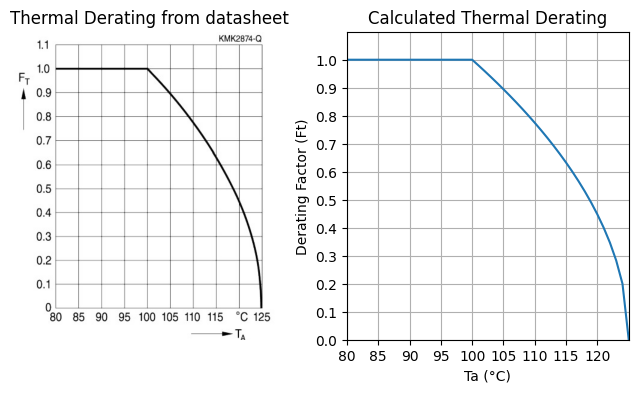

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

img = plt.imread("../01_llc_tank/03_figs/Capa_thermal_derating.jpg")
axes[0].imshow(img)
axes[0].axis("off")
axes[0].set_title("Thermal Derating from datasheet")


Ta_arr= np.arange(80,125+1,1)
Fa_arr=[]
for Ta in Ta_arr:
    if Ta>100:
        Delta_T= T_max-Ta
        PD_uW_max = Delta_T/R_TH
        Ir_rms_max_Ta=sqrt(PD_uW_max/ESR_u)
        Fa = Ir_rms_max_Ta/Ir_rms_max
        Fa_arr.append(Fa)
    else: 
        Fa_arr.append(1)
        
axes[1].plot(Ta_arr, Fa_arr)

axes[1].set_xlabel("Ta (°C)")
axes[1].set_ylabel("Derating Factor (Ft)")
axes[1].set_title("Calculated Thermal Derating")

axes[1].set_xticks(np.arange(80, 125, 5))
axes[1].set_yticks(np.arange(0, 1.1, 0.1))

axes[1].grid(True)
axes[1].set_ylim([0,1.1])
axes[1].set_xlim([80,125])

### Resonant capacitors configuration <a class="title_class" id="title_12"></a>

There are two possible configurations for the resonant capacitors:

- All capacitors in parallel:

which is the classic LLC configuration and offers simplicity in layout.
- Dividing the capacitors between the high side and low side:

which helps balance HV+ and HV-.

Below is a simulation of both solutions. We can see that the voltage and current of each capacitor are almost identical in both configurations, and all other voltages and currents are also very similar.

You can donwload the LTSPICE file using this <a src =".\02_simulation\03_Res_capacitor\Comparaison_Res_Capas_Archi.asc">Link</a>.

In [83]:
first_part_path = "./03_figures/"

fig_counter = One_figure_with_captions(
    fig_counter, 
    "Comparaison_Res_Capas_Archi.png",
    "Simulation of resonant capacitor configurations",
    first_part_path= first_part_path, 
    width = 19
)

## References  <a class="title_class" id="title_13"></a>
<a id="referencesID_03_1"></a> [1] [Hong Huang, *Designing an LLC Resonant
Half-Bridge Power Converter*. Available](https://bbs.dianyuan.com/upload/community/2013/12/01/1385867010-65563.pdf)

<a id="referencesID_03_2"></a> [2] 
[B40910 Aluminum electrolytic capacitors datasheet](https://product.tdk.com/system/files/dam/doc/product/capacitor/aluminum-electrolytic/hybrid-polymer/data_sheet/20/30/db/aec/b40910.pdf)

<a id="referencesID_03_3"></a> [3] 
[B3267*L Film Capacitors](https://product.tdk.com/system/files/dam/doc/product/capacitor/film/mkp_mfp/data_sheet/20/20/db/fc_2009/mkp_b32671l_672l.pdf)


<a id="referencesID_03_4"></a> [4] 
[EMHS Aluminum electrolytic capacitors datasheet](https://www.mouser.fr/datasheet/2/420/Chemi_Con_MHSRA_e-3313675.pdf)

